# Global Mean Surface Temperature

This notebook uses similar techniques to `ECS_Gregory_method.ipynb`. Please refer to that notebook for details.

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(name='dask-scheduler',
                       cores=4,                # Total number of cores per job
                       memory='16GB',          # Total amount of memory per job
                       processes=4,            # Number of Python processes per job
                       interface='ib0',        # Network interface to use like eth0 or ib0
                       queue='shared',      
                       project='ch0636',     
                       walltime='12:00:00',
                       asynchronous=0)
print(cluster.job_script())

#client = Client(n_workers=8, threads_per_worker=2, memory_limit='256GB')

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p shared
#SBATCH -A ch0636
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=15G
#SBATCH -t 12:00:00

/work/ch0636/g300046/conda_envs/dask/bin/python -m distributed.cli.dask_worker tcp://10.50.41.5:36862 --nthreads 1 --nprocs 4 --memory-limit 4.00GB --name name --nanny --death-timeout 60 --interface ib0



In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.50.41.5:36862 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.scale(64)

In [140]:
client.shutdown()
client.close()

In [6]:
dkrz_url = "/work/ik1017/Catalogs/mistral-cmip6.json"
pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(dkrz_url)
col

,unique
activity_id,19
institution_id,39
source_id,91
experiment_id,206
member_id,406
table_id,38
variable_id,1158
grid_label,12
dcpp_init_year,60
version,567


In [7]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp370',
 'ssp370-lowNTCF',
 'ssp370SST',
 'ssp370SST-lowNTCF',
 'ssp370SST-lowBC',
 'ssp370SST-ssp126Lu',
 'ssp370SST-lowAer',
 'ssp370SST-lowCH4',
 'ssp370pdSST',
 'esm-ssp585',
 'ssp534-over-bgc',
 'ssp585-bgc',
 'ssp245-GHG',
 'ssp245-aer',
 'ssp245-nat',
 'ssp245-stratO3',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp585',
 'ssp126',
 'ssp245',
 'ssp119',
 'ssp434',
 'ssp460',
 'ssp534-over']

In [54]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp126', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,4,1,1
ACCESS-ESM1-5,4,1,1
AWI-CM-1-1-MR,4,1,1
BCC-CSM2-MR,4,1,1
CAMS-CSM1-0,4,1,1
CESM2-WACCM,4,1,1
CIESM,4,1,1
CMCC-CM2-SR5,4,1,1
CanESM5,4,1,1


In [55]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,NaN,v20191108,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp126,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
3,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
4,CMIP,CSIRO,ACCESS-ESM1-5,historical,r1i1p1f1,Amon,tas,gn,NaN,v20191115,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,205101-206012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1182,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,206101-207012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1183,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,207101-208012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1184,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,208101-209012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...


In [56]:
col_subset.df.groupby(['source_id', 'experiment_id']).get_group(('NorESM2-MM', 'historical')).agg('path').values

array(['/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_185001-185912.nc',
       '/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_186001-186912.nc',
       '/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_187001-187912.nc',
       '/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_188001-188912.nc',
       '/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_189001-189912.nc',
       '/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_Nor

In [77]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):

    print(df.agg('path').values)
    ds = xr.open_mfdataset(df.agg('path').values, use_cftime=True)
#    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict) 

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [124]:
dsets_ = dask.compute(dict(dsets))[0]

In [115]:
dsets_.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'])

In [116]:
dsets_['ACCESS-CM2']['historical']

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 192, time: 1980)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 ...
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1980, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T06:41:46Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    history:                2019-11-08T06:41:46Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institution_id:         CSIRO-ARCCSS
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-historical; Local ID: bj594; Variable: t...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 0950-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [117]:
dsets_['IPSL-CM6A-LR']['historical'].time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeGregorian(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeGregorian(2014, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeGregorian(2014, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2014, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
    height   float64 ...
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1850-01-01 00:00:00
    bounds:         time_bounds

In [118]:
access = dsets_['ACCESS-CM2']['historical']
access.time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2014, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2014, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 ...
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [119]:
import datetime as cftime
access.coords['time'] = ([cftime.datetime(date.year, date.month, date.day, date.hour, date.minute, date.second)
                                    for date in access.time.values])

In [122]:
access.tas.values

array([[[252.68433, 252.65332, 252.6128 , ..., 252.87817, 252.87573,
         252.87354],
        [253.29565, 253.28394, 253.27759, ..., 253.29736, 253.2898 ,
         253.22339],
        [253.3252 , 253.30762, 253.29004, ..., 253.55713, 253.46411,
         253.42651],
        ...,
        [237.47144, 237.4419 , 237.44238, ..., 237.82227, 237.68164,
         237.52588],
        [237.28784, 237.2273 , 237.27979, ..., 237.6604 , 237.43701,
         237.32129],
        [237.9082 , 237.771  , 237.74243, ..., 237.96094, 237.9331 ,
         237.89722]],

       [[234.3728 , 234.39355, 234.3728 , ..., 234.45557, 234.42432,
         234.59985],
        [231.13477, 231.11304, 231.03589, ..., 231.6416 , 231.59204,
         231.41699],
        [231.75098, 231.61597, 231.46948, ..., 232.33862, 232.12598,
         231.92627],
        ...,
        [235.32202, 235.3623 , 235.39502, ..., 235.51147, 235.52051,
         235.40674],
        [234.78589, 234.79663, 234.76147, ..., 234.77832, 234.77808,
   

In [39]:
for k, v in tqdm(dsets_.items()):
    print(v.values())

dict_values([<xarray.Dataset>
Dimensions:  (lat: 144, lon: 192, time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 ...
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1980, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T06:41:46Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.

In [70]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [126]:
import datetime as cftime

expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    
    for ds in expt_dsets:
       # time_axis = pd.to_datetime(["{:04d}-{:02d}-{:02d}".format(date.year, date.month, date.day) 
       #                             for date in ds.time.values])
       # time_axis = ([cftime.datetime(date.year, date.month, date.day, date.hour, date.minute, date.second)
       #                             for date in ds.time.values])
        time_axis = ([cftime.datetime(date.year, date.month, 1)
                                    for date in ds.time.values])
        ds.coords['time'] = time_axis
        #print(len(ds.coords['time']), len(ds.coords['cftime']))
        
        
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
 #                            .swap_dims({'time': 'cftime'})
 #                            .drop('time')
 #                            .coarsen(year=12).mean()
                      for expt in expts]
    
    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CAMS-CSM1-0
CESM2-WACCM
CIESM
CMCC-CM2-SR5
CanESM5
EC-Earth3-Veg
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-ESM4
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM



In [127]:
dsets_aligned['ACCESS-CM2'].tas.values

array([[285.19111629, 285.21798211, 286.13884884, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 289.70922929,
        288.66541006, 287.91008376],
       [         nan,          nan,          nan, ..., 290.70706058,
        289.78731528, 289.2095726 ],
       [         nan,          nan,          nan, ..., 293.19746256,
        292.34869691, 291.76579411]])

In [128]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [129]:
dsets_aligned_['ACCESS-CM2']

<xarray.Dataset>
Dimensions:        (experiment_id: 4, time: 3012)
Coordinates:
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2100-12-01
    height         float64 2.0
Data variables:
    tas            (experiment_id, time) float64 285.2 285.2 ... 292.3 291.8

In [50]:
GCM1 = dsets_aligned_['ACCESS-CM2'].reset_coords(drop=True)
GCM2 = dsets_aligned_['ACCESS-ESM1-5'].reset_coords(drop=True)
source_ids = ['ACCESS-CM2', 'ACCESS-ESM1-5']
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})
big_ds = xr.concat([GCM1, GCM2], dim=source_da)

In [23]:
for gcm, ds in dsets_aligned_.items():
    print(ds.time.min().values, ds.time.max().values, gcm, type(ds.time.dt.day))

1850-01-16T12:00:00.000000000 2100-12-16T12:00:00.000000000 ACCESS-CM2 <class 'xarray.core.dataarray.DataArray'>
1850-01-16T12:00:00.000000000 2100-12-16T12:00:00.000000000 ACCESS-ESM1-5 <class 'xarray.core.dataarray.DataArray'>
1850-01-16T12:00:00.000000000 2100-12-16T12:00:00.000000000 AWI-CM-1-1-MR <class 'xarray.core.dataarray.DataArray'>
1850-01-16T12:00:00.000000000 2100-12-16T12:00:00.000000000 BCC-CSM2-MR <class 'xarray.core.dataarray.DataArray'>
1850-01-16T12:00:00.000000000 2099-12-16T12:00:00.000000000 CAMS-CSM1-0 <class 'xarray.core.dataarray.DataArray'>


TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

In [51]:
big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 4, source_id: 2, time: 3012)
Coordinates:
  * source_id      (source_id) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5'
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T1...
Data variables:
    tas            (source_id, experiment_id, time) float64 285.2 ... 291.3

In [74]:
source_da

<xarray.DataArray 'source_id' (source_id: 28)>
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5',
       'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3',
       'FIO-ESM-2-0', 'GFDL-ESM4', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM'], dtype='<U13')
Coordinates:
  * source_id  (source_id) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NorESM2-MM'

In [130]:
source_ids = list(dsets_aligned_.keys())
print(source_ids)
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM']


<xarray.Dataset>
Dimensions:        (experiment_id: 4, source_id: 26, time: 5412)
Coordinates:
  * source_id      (source_id) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * time           (time) object 1850-01-01 1850-02-01 ... 2300-11-01 2300-12-01
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    tas            (source_id, experiment_id, time) float64 285.2 285.2 ... nan

In [132]:
dsets_aligned_['ACCESS-CM2']

<xarray.Dataset>
Dimensions:        (experiment_id: 4, time: 3012)
Coordinates:
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2100-12-01
    height         float64 2.0
Data variables:
    tas            (experiment_id, time) float64 285.2 285.2 ... 292.3 291.8

In [133]:
dsets_aligned_.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'])

In [134]:
big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 4, source_id: 26, time: 5412)
Coordinates:
  * source_id      (source_id) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * time           (time) object 1850-01-01 1850-02-01 ... 2300-11-01 2300-12-01
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    tas            (source_id, experiment_id, time) float64 285.2 285.2 ... nan

In [135]:
df_all = big_ds.sel(time=slice(cftime.datetime(1900,1,1), cftime.datetime(2100,12,31))).to_dataframe().reset_index()
df_all.head()

,experiment_id,source_id,time,tas
0,historical,ACCESS-CM2,1900-01-01,285.105561
1,historical,ACCESS-CM2,1900-02-01,285.457167
2,historical,ACCESS-CM2,1900-03-01,286.029045
3,historical,ACCESS-CM2,1900-04-01,287.114317
4,historical,ACCESS-CM2,1900-05-01,287.935325


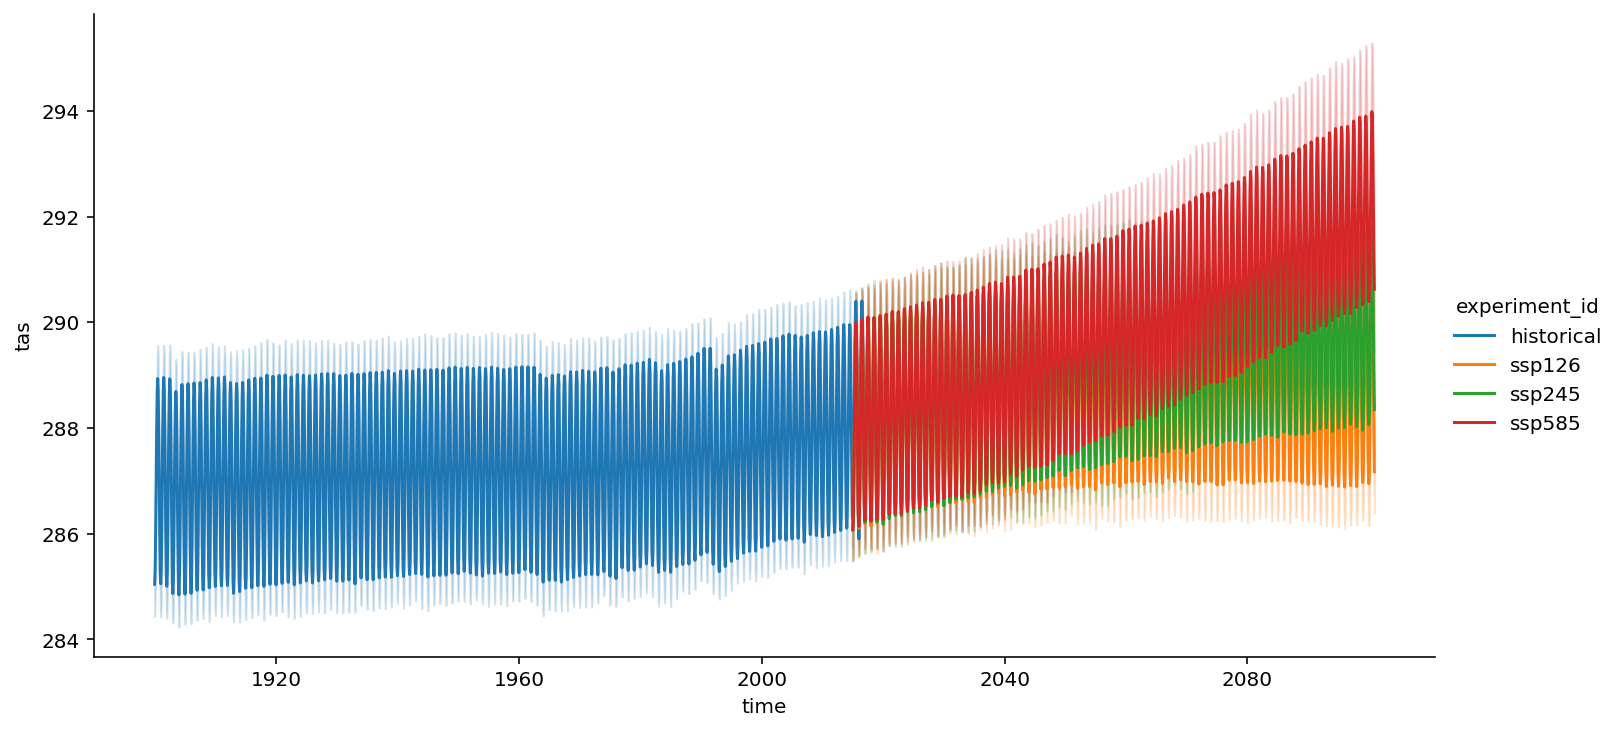

In [136]:
sns.relplot(data=df_all,
            x="time", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=2);

In [139]:
# why are there axis legends for 9, 10 - doesn't make sense
df_all.to_csv('cmip6-tas-r1i1p1f1-amon.csv', index=False)

In [30]:
df_all.groupy(['sourc_id'])

,experiment_id,source_id,time,tas
0,historical,ACCESS-CM2,1900-01-15 12:00:00,NaN
1,historical,ACCESS-CM2,1900-01-16 00:00:00,NaN
2,historical,ACCESS-CM2,1900-01-16 12:00:00,285.105561
3,historical,ACCESS-CM2,1900-01-17 12:00:00,NaN
4,historical,ACCESS-CM2,1900-02-14 00:00:00,NaN
...,...,...,...,...
903963,ssp585,NorESM2-MM,2100-11-17 00:00:00,NaN
903964,ssp585,NorESM2-MM,2100-12-15 12:00:00,NaN
903965,ssp585,NorESM2-MM,2100-12-16 00:00:00,NaN
903966,ssp585,NorESM2-MM,2100-12-16 12:00:00,289.983206
